# Adjusting correlation parameters for entropy scaling of viscosity

## Goal

- Read in experimental data for viscosity of a pure substance.
- Use the `DataSet`, `Loss` and `Estimator` objects to store and work with experimental data.
- Define a `cost` function that will be used with `scipy.optimize.least_squares`.
- Run the optimization.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import seaborn as sns
from si_units import BAR, KELVIN, KILOGRAM, METER, MILLI, PASCAL, SECOND, RGAS

from feos.eos import EquationOfState, State, Contributions
from feos.pcsaft import Identifier, PcSaftParameters, PcSaftRecord, PureRecord
from feos.eos.estimator import Estimator, Loss, DataSet, Phase

sns.set_context('talk')
sns.set_palette('Dark2')
sns.set_style('ticks')
colors = sns.palettes.color_palette('Dark2', 5)
plt.rcParams['figure.figsize'] = [12,7]

# `DataSet` objects

FeO$_\text{s}$ provides a range of data structures that facilitate the adjustment of parameters. One such structure is the `DataSet`, which serves as a storage unit for experimental data. When working with a specific model, a `DataSet` enables the evaluation of a `cost` function. How this cost function is defined depends on the property that you want to predict with your equation of state. In this notebook, we use the viscosity where the cost function is the relative difference between the experimental data and the model prediction.

A DataSet encompasses the following components:

- The `target`: This refers to the experimental data associated with the property for which we intend to adjust parameters. In our case, this is the viscosity.
- Other properties: These are necessary for determining the thermodynamic conditions. For instance, temperature is required for vapor pressure calculations, while liquid density computations necessitate temperature and pressure. For the viscosity, we use pressure, temperature and the phase (liquid or vapor) as input.
- Each property available in FeO$_\text{s}$ is accompanied by a corresponding DataSet constructor.

In [2]:
# read data from file into DataFrame
data = pd.read_csv("data/hexane_viscosity.csv")
# map strings for phase to Phase objects
phase = [Phase.Vapor if p == 'vapor' else Phase.Liquid for p in data.phase]

# construct a `DataSet` for vapor pressure
dataset = DataSet.viscosity(
    target=data["viscosity / mPas"].values * MILLI * PASCAL * SECOND,
    temperature=data["temperature / K"].values * KELVIN,
    pressure=data["pressure / bar"].values * BAR,
    phase=phase
)

For `DataSet.viscosity` we have to supply the experimental data for viscosity, temperature, and pressure.

Optionally, a list of `Phase` objects can be supplied (via the `phase` argument) in which case not the stable phase is calculated for given temperature and pressure but the possibly instable phase according to the input phase.

# `Estimator` and `Loss` objects

To collect the `DataSet` objects for the properties we wish to adjust parameters for, we can assemble them into an `Estimator` object. The `Estimator` requires the following inputs:

- A list of `DataSet` objects.
- A corresponding list of `weights`, with each weight assigned to a specific `DataSet`.
- A list of `losses`, where each `DataSet` has an associated loss function.

In our case, there is only a single `DataSet` so we can ignore the `weights`. Since our data comes from a correlation (from the NIST WebBook), we don't need a loss function.

In [3]:
estimator = Estimator(data=[dataset],weights=[1],losses=[Loss.linear()])

# Defining a cost function

When using `scipy`'s `least_squares` solver, it requires a function to calculate the cost or residuals. The first argument of this function must be the parameter vector that's being optimized. Therefore, it is necessary to define this function in Python before working with `least_squares`.

To simplify the process, we create two functions:

- `eos_from_parameters`: This function constructs the parameters and equation of state based on the current parameter vector. Since FeO$_\text{s}$ does not allow mutation of an existing `EquationOfState` object, generating a new equation of state is necessary. We can use this function later to generate the equation of state for the final parameters.
- `cost`: Taking the parameters and estimator as inputs, this function builds the equation of state, calculates the cost of the current model, and returns the result.

These functions aid in the seamless integration of the solver, allowing for the generation of the equation of state and the calculation of the model's cost.

In [4]:
# extract PC-SAFT parameters, identifier and molarweight, which are kept constant during optimization
hexane = PcSaftParameters.from_json(["hexane"], "../../../parameters/pcsaft/esper2023.json").pure_records[0]
identifier = hexane.identifier
saft = hexane.model_record
mw = hexane.molarweight
m, sigma, epsilon_k = saft.m, saft.sigma, saft.epsilon_k

def eos_from_parameters(c):
    """Returns equation of state (PC-SAFT) for current parameters."""
    global m, sigma, epsilon_k, identifier, mw
    model_record = PcSaftRecord(m, sigma, epsilon_k, viscosity=c)
    pure_record = PureRecord(identifier, mw, model_record)
    parameters = PcSaftParameters.from_records([pure_record])
    return EquationOfState.pcsaft(parameters)

def cost(p, estimator):
    """Calculates cost function for current parameters."""
    return estimator.cost(eos_from_parameters(p))

# Adjust parameters

To begin parameter adjustment, there are two additional requirements:

1. An initial guess for the parameters.
2. Bounds for the parameters.

It is crucial to note that trying multiple combinations of initial parameters is recommended to avoid getting stuck in a local minimum.

Once these prerequisites are fulfilled, we can invoke `least_squares` with `args=(estimator, )` as an argument for the `cost` function. Please note that the tuple syntax is necessary in this case.

In [5]:
%%time
initial_parameters = [0.0]*4 
fitted_parameters = least_squares(cost, initial_parameters, args=(estimator,), verbose=2).x

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.7163e-03                                    6.45e-03    
       1              2         4.5509e-04      4.26e-03       1.00e+00       2.23e-03    
       2              3         1.6840e-05      4.38e-04       1.75e+00       2.57e-04    
       3              4         1.6086e-07      1.67e-05       1.21e+00       1.39e-05    
       4              5         8.4360e-08      7.65e-08       2.34e-01       7.53e-08    
       5              6         8.4357e-08      3.66e-12       4.59e-03       2.37e-11    
`gtol` termination condition is satisfied.
Function evaluations 6, initial cost 4.7163e-03, final cost 8.4357e-08, first-order optimality 2.37e-11.
CPU times: user 59.3 ms, sys: 6.51 ms, total: 65.8 ms
Wall time: 64.5 ms


To provide statistics during the adjustment process, we can utilize the `verbose=2` option, which prints relevant information. However, our primary interest lies in obtaining the optimal parameters. These parameters can be accessed from the `x` field of the `OptimizeResult` object generated by the `least_squares` function.

Once the adjustment is complete, we can investigate the results. A quick and straightforward method for analyzing the optimization results is to use the `Estimator.mean_absolute_relative_difference` method. This method returns the mean absolute relative difference (MARD) for each `DataSet`, without applying losses or weights. It is important to exercise caution when dealing with `NaN` values, as any predictions resulting in `NaN` are filtered out and thus not immediately visible in the reported values.

It's essential to note that the resulting MARD **does not include** an evaluation of the loss functions or weights. Therefore, it may not equal the property that is minimized in the optimization process.

In [6]:
print("Adjusted correlation parameters")
print("c    = {}".format(fitted_parameters))

mard = estimator.mean_absolute_relative_difference(eos_from_parameters(fitted_parameters)) * 100
print("MARD = {:<5.4} %".format(mard[0]))

Adjusted correlation parameters
c    = [-1.20010418 -2.15742133  0.24509729  0.21828778]
MARD = 0.2038 %


# Plot resuts

We can now use our results and calcuate the phase diagram and have a visual inspection of our parameters. Here, we calculate the reduced logarithmic viscosity to use the entropy scaled depiction.

In [7]:
fitted_eos = eos_from_parameters(fitted_parameters)
results = []
for _, (t, p, viscosity, phase) in data.iterrows():
    s = State(fitted_eos, temperature=t*KELVIN, pressure=p*BAR, density_initialization=phase)
    results.append({
        's_res': s.molar_entropy(Contributions.Residual) / RGAS / m,
        'ln_eta_nist': np.log(viscosity * MILLI * PASCAL * SECOND / s.viscosity_reference()),
        'ln_eta_saft': s.ln_viscosity_reduced(),
        'temperature': t,
        'pressure': p,
    })
    
# collect into DataFrame
results_df = pd.DataFrame(results)

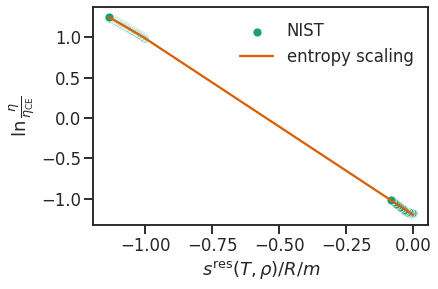

In [8]:
sns.scatterplot(
    data=results_df, x='s_res', y='ln_eta_nist', 
    color=colors[0], label='NIST'
)
sns.lineplot(
    data=results_df, x='s_res', y='ln_eta_saft', 
    color=colors[1], label='entropy scaling'
)

plt.xlabel(r"$s^\text{res}(T, \rho) / R / m$")
plt.ylabel(r"$\ln\frac{\eta}{\eta_\text{CE}}$")
plt.legend(frameon=False);

# Summary

- The `Estimator` object in FeO$_\text{s}$ allows the collection of `DataSet` objects for adjusting parameters.
  - The `Estimator` takes a list of `DataSet` objects, weights, and `Loss` objects as inputs.
  - For `DataSet.viscosity`, it calculates the cost of a model by evaluating the relative difference between the model's prediction and experimental data in each `DataSet`.
- To work with `scipy`'s `least_squares` solver, a cost function is required.
  - Two functions, `eos_from_parameters` and `cost`, are built for this purpose.
  - `eos_from_parameters` constructs the parameters and equation of state for the current parameter vector.
  - `cost` calculates and returns the cost of the current model based on the parameters and estimator.
- Initial parameter guesses and parameter bounds are necessary for parameter adjustment.
  - Checking multiple combinations of initial parameters is recommended to avoid local minima (not shown in this notebook).
- For `DataSet.viscosity`, the `Estimator.mean_absolute_relative_difference` method provides the mean absolute relative difference (MARD) without applying weights or losses.